# Using Lowess Regression in openEO for Filling Missing Time Series Data

In numerous scenarios, time series data may exhibit gaps or missing values. Such gaps can arise due to various reasons, including cloud cover. These missing values can significantly impact the quality of the data and the subsequent analysis.

In statistical analysis, various tools are available for filling in such missing values, and herein, we employ one such tool. In this notebook we will show how the Lowess model can be used to fill such gaps in time series data, using a regression technique [[ref.]](https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html).

It provides a flexible method to identify patterns and relationships within the data. The main idea of Lowess is to fit simple models to small subsets of the data, thus creating a function that reflects the underlying structure. 

Here, we implement Lowess smoothing directly within the openEO User-Defined Function (UDF).

References:
* https://en.wikipedia.org/wiki/Local_regression
* https://sites.stat.washington.edu/courses/stat527/s14/readings/Cleveland_JASA_1979.pdf

In [3]:
import openeo
import matplotlib.pyplot as plt
import xarray as xr

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


For this use case, we implement the Lowess regression method specifically on the NO2 band of the `SENTINEL_5P_L2` collection for a particular spatio-temporal extent.

In [4]:
# Load Data for three months
No2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2021-04-01", "2021-06-01"],
    spatial_extent={
        "west": -118.36136,
        "south": 33.850356,
        "east": -117.90809,
        "north": 34.15711,
    },
    bands=["NO2"],
)

# Now aggregate by day
No2 = No2.aggregate_temporal_period(reducer="mean", period="day")

In this UDF, we import an external library to apply lowess on the input DataArray. This array is checked for NaN values over time, and then LOWESS interpolation is used to fill in the NaNs. If all values are NaN, that part of the result array is filled with zeros. 
The result is the processed data with either interpolated or zero-filled values in those gaps.

For more information, please visit [this page](https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html).

In [ ]:
# define UDF

udf = openeo.UDF(
    """
import xarray as xr
import numpy as np
from openeo.udf import inspect
from openeo.metadata import CollectionMetadata
from statsmodels.nonparametric.smoothers_lowess import lowess

def lowess_along_axis(arr: np.ndarray) -> np.ndarray:
    if not np.all(np.isnan(arr)):
        # Get non-NaN indices
        not_nan_indices = np.where(~np.isnan(arr))[0]
        
        # Interpolate NaN values using lowess
        smoothed = lowess(arr[not_nan_indices], not_nan_indices, frac=0.2)
        
        # Create a copy of the original series
        filled_series = arr.copy()
        
        # Replace NaN values with interpolated values
        filled_series[np.isnan(filled_series)] = np.interp(np.arange(len(filled_series)),
                                                smoothed[:, 0],
                                                smoothed[:, 1])[np.isnan(filled_series)]
    else:
        filled_series = arr.copy()
    return filled_series
    
def apply_datacube(cube: xarray.DataArray, context: dict) -> xarray.DataArray:
    
    res_arr = xr.apply_ufunc(lowess_along_axis, 
    cube,
    input_core_dims=[['t']], 
    output_core_dims=[['t']], 
    vectorize=True)    
    return res_arr
    
"""
)

In [6]:
No2_filled = No2.apply_dimension(process=udf, dimension="t")

Let us download the actual observed data with filled result.

In [7]:
No2_filled.execute_batch(
    title="Filled NO2 data with Lowess", outputfile="NO2_Interpolated.nc"
)

0:00:00 Job 'j-240614e312ca43df8dbabe9850558f94': send 'start'
0:00:20 Job 'j-240614e312ca43df8dbabe9850558f94': queued (progress 0%)
0:00:25 Job 'j-240614e312ca43df8dbabe9850558f94': queued (progress 0%)
0:00:32 Job 'j-240614e312ca43df8dbabe9850558f94': queued (progress 0%)
0:00:40 Job 'j-240614e312ca43df8dbabe9850558f94': queued (progress 0%)
0:00:50 Job 'j-240614e312ca43df8dbabe9850558f94': queued (progress 0%)
0:01:02 Job 'j-240614e312ca43df8dbabe9850558f94': queued (progress 0%)
0:01:17 Job 'j-240614e312ca43df8dbabe9850558f94': running (progress N/A)
0:01:37 Job 'j-240614e312ca43df8dbabe9850558f94': running (progress N/A)
0:02:01 Job 'j-240614e312ca43df8dbabe9850558f94': running (progress N/A)
0:02:31 Job 'j-240614e312ca43df8dbabe9850558f94': running (progress N/A)
0:03:08 Job 'j-240614e312ca43df8dbabe9850558f94': running (progress N/A)
0:03:55 Job 'j-240614e312ca43df8dbabe9850558f94': running (progress N/A)
0:04:56 Job 'j-240614e312ca43df8dbabe9850558f94': running (progress N/A)


<BatchJob job_id='j-240614e312ca43df8dbabe9850558f94'>

For a comparative visualisation, let's also download the raw observed data without any filled information.

In [9]:
job = No2.execute_batch(
    title="Observed NO2 data before Lowess", outputfile="NO2_withNAN.nc"
)
job

0:00:00 Job 'j-2406142db7f849658a682e11225d66e0': send 'start'
0:00:20 Job 'j-2406142db7f849658a682e11225d66e0': created (progress 0%)
0:00:25 Job 'j-2406142db7f849658a682e11225d66e0': created (progress 0%)
0:00:32 Job 'j-2406142db7f849658a682e11225d66e0': created (progress 0%)
0:00:40 Job 'j-2406142db7f849658a682e11225d66e0': created (progress 0%)
0:00:57 Job 'j-2406142db7f849658a682e11225d66e0': running (progress N/A)
0:01:10 Job 'j-2406142db7f849658a682e11225d66e0': running (progress N/A)
0:01:35 Job 'j-2406142db7f849658a682e11225d66e0': running (progress N/A)
0:01:54 Job 'j-2406142db7f849658a682e11225d66e0': running (progress N/A)
0:02:18 Job 'j-2406142db7f849658a682e11225d66e0': running (progress N/A)
0:02:48 Job 'j-2406142db7f849658a682e11225d66e0': running (progress N/A)
0:03:26 Job 'j-2406142db7f849658a682e11225d66e0': running (progress N/A)
0:04:13 Job 'j-2406142db7f849658a682e11225d66e0': running (progress N/A)
0:05:11 Job 'j-2406142db7f849658a682e11225d66e0': finished (progr

<BatchJob job_id='j-2406142db7f849658a682e11225d66e0'>

Moreover, upon completing the job, check the amount of credit consumed. 

In [9]:
print(f"credit consumed is: {job.describe()['costs']} openEO credits")

credit consumed is: 2 openEO credits


This information is also accessible in the details section of your job within the [web editor](https://openeo.dataspace.copernicus.eu) or under the [reporting section](https://marketplace-portal.dataspace.copernicus.eu/reporting) in the marketplace.

### Let's plot the result

Furthermore, let's try to plot the mean of the obtained result.

In [10]:
filled = xr.load_dataset("NO2_Interpolated.nc")
observed = xr.load_dataset("NO2_withNAN.nc")

In [11]:
# Calculate the mean over the y and x dimensions for both observed and filled data
mean_obs_NO2 = observed.NO2.mean(dim=["y", "x"])
mean_filled_NO2 = filled.NO2.mean(dim=["y", "x"])

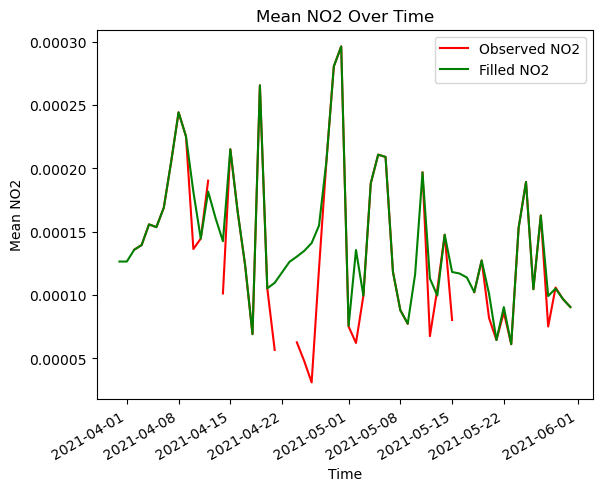

In [12]:
fig, ax = plt.subplots()
mean_obs_NO2.plot.line(ax=ax, label="Observed NO2", color="red")
mean_filled_NO2.plot.line(ax=ax, label="Filled NO2", color="green")

ax.legend()
ax.set_title("Mean NO2 Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Mean NO2")

plt.show()

Therefore, it is noticeable that the gaps observed in the original observations have been successfully filled. Furthermore, the model effectively preserves the overall trend of the observations with smoothening due to the nature of lowess function.
